In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split

sns.set_style("darkgrid")

In [15]:
def RMSE(y_hat: pl.Series, y_obs: pl.DataFrame) -> float:
    return (((y_hat - y_obs.to_series()) ** 2).sum() / y_obs.shape[0]) ** 0.5

def R2(y_pred: pl.Series, y_obs: pl.DataFrame):
    return 1 - ((y_pred - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def Q2(y_hat: pl.Series, y_obs: pl.DataFrame):
    return 1 - ((y_hat - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def standarize(df: pl.DataFrame):
    return df.select((pl.all() - pl.all().mean())/pl.all().std())

# Import niestandaryzowanego zestawu danych dane_leki.xlsx

In [3]:
input_matrix = pl.read_excel(source="dane_leki.xlsx", engine="openpyxl")

In [4]:
input_matrix.head()

Nazwa,logK HSA,logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA,Zbiór
str,f64,f64,i64,i64,i64,str
"""acetaminophen""",-0.79,-0.63,2,0,2,"""t"""
"""acetylsalicylic acid""",-0.23,1.22,1,0,4,"""t"""
"""bromazepam""",0.38,0.57,1,0,3,"""t"""
"""carbamazepine""",0.69,0.68,0,0,3,"""t"""
"""chlorpromazine""",1.18,1.5,0,0,2,"""t"""


# Podział danych na zbiór treningowy i testowy

66:33

random_state = 42

In [5]:
descriptors = input_matrix.select(
    pl.nth(range(2,6))
)

In [6]:
descriptors.head()

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,i64,i64,i64
-0.63,2,0,2
1.22,1,0,4
0.57,1,0,3
0.68,0,0,3
1.5,0,0,2


In [7]:
Y_obs = input_matrix.select(pl.nth(1))

In [8]:
Y_obs.head()

logK HSA
f64
-0.79
-0.23
0.38
0.69
1.18


In [9]:
X_training, X_validation, Y_training, Y_validation = train_test_split(
    descriptors, Y_obs, test_size=0.33, random_state=42
)

In [10]:
X_training.head()

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,i64,i64,i64
1.32,3,2,5
1.22,1,0,4
1.5,0,0,2
0.26,2,0,1
0.57,1,0,3


In [11]:
Y_training.head()

logK HSA
f64
0.08
-0.23
1.18
-0.42
0.38


# Standaryzacja danych

In [16]:
X_training_std = standarize(X_training)

In [17]:
X_validation_std = standarize(X_validation)

In [18]:
Y_training_std = standarize(Y_training)

In [19]:
Y_validation_std = standarize(Y_validation)

# Analiza PCA

In [20]:
X_training_std.corr()

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,f64,f64,f64
1.0,-0.641826,0.385608,-0.410865
-0.641826,1.0,-0.380036,0.439622
0.385608,-0.380036,1.0,0.093667
-0.410865,0.439622,0.093667,1.0


In [21]:
pca_model = PCA(n_components=4)

In [22]:
pca_model.fit(X_training_std)

PCA(n_components=4)

Wartości własne

In [23]:
pca_model.explained_variance_

array([2.16310541, 1.0935978 , 0.38892524, 0.35437155])

Wektory własne

In [24]:
pca_model.components_

array([[-0.59174596,  0.59710501, -0.35859913,  0.40584354],
       [ 0.02360091,  0.00835668,  0.73806585,  0.67426402],
       [ 0.58597297, -0.14243249, -0.54730579,  0.58034906],
       [ 0.55309618,  0.78937238,  0.16468708, -0.20941353]])

Główne składowe

In [25]:
PC_training = pl.DataFrame(
    pca_model.fit_transform(X_training_std),
    schema=[f"PC{i+1}" for i in range(pca_model.n_components_)],
)

In [26]:
PC_training.head()

PC1,PC2,PC3,PC4
f64,f64,f64,f64
0.603434,0.597956,0.359986,1.536812
-0.187127,-0.54754,0.751389,0.107048
-1.344388,-1.31067,0.41031,-0.12629
0.305835,-1.714133,-1.032622,0.479863
0.047036,-0.948123,-0.037072,-0.208108


In [27]:
PC_validation = pl.DataFrame(
    pca_model.fit_transform(X_validation_std),
    schema=[f"PC{i+1}" for i in range(pca_model.n_components_)],
)

In [28]:
PC_validation.head()

PC1,PC2,PC3,PC4
f64,f64,f64,f64
-0.483449,-1.227635,-0.403305,-0.062323
1.425497,-0.454747,0.802647,0.462208
-0.660081,-1.083157,0.490987,-0.174383
-0.508456,1.940639,0.251906,-0.411192
-1.767068,0.455057,-0.534033,0.454544


# Metoda walidacji krzyżowej KFold
n_splits = 10

shuffle = True

random_state = 0

In [29]:
KFold_model = KFold(n_splits=10, shuffle=True, random_state=0)

In [30]:
def RMSE_cv(validation_sets, X_training: pl.DataFrame, Y_training: pl.DataFrame) -> pl.Float64:
    residues = pl.Series(dtype=pl.Float64)

    for validation_set in validation_sets:
        x = (
            X_training.with_row_index()
            .filter(~pl.col("index").is_in(validation_set))
            .drop(pl.col("index"))
        )

        y = (
            Y_training.with_row_index()
            .filter(~pl.col("index").is_in(validation_set))
            .drop(pl.col("index"))
        )

        PCR_model = LinearRegression().fit(X=x, y=y)

        prediction = PCR_model.predict(
            X_training.with_row_index()
            .filter(pl.col("index").is_in(validation_set))
            .drop(pl.col("index"))
        )

        references = (
            Y_training.with_row_index()
            .filter(pl.col("index").is_in(validation_set))
            .drop(pl.col("index"))
        )

        residues.append(pl.Series((prediction - references).flatten()))

    return np.sqrt((residues**2).sum())

In [31]:
def RMSE_c(X_training: pl.DataFrame, Y_training: pl.DataFrame) -> pl.Float64 | float:

    PCR_model = LinearRegression().fit(X_training, Y_training)

    return RMSE(
        PCR_model.predict(X_training).flatten(),
        Y_training
    )

# Wykres zależności $RMSE_c$ i $RMSE_{cv}$ od liczby uwzględnianych głównych składowych

In [32]:
validation_sets = [
    validation_set
    for (_, validation_set) in KFold_model.split(PC_training, Y_training_std)
]

In [33]:
PC_training.select(pl.nth(range(0,4)))

PC1,PC2,PC3,PC4
f64,f64,f64,f64
0.603434,0.597956,0.359986,1.536812
-0.187127,-0.54754,0.751389,0.107048
-1.344388,-1.31067,0.41031,-0.12629
0.305835,-1.714133,-1.032622,0.479863
0.047036,-0.948123,-0.037072,-0.208108
…,…,…,…
-0.675902,1.325922,0.605309,-0.624681
-1.35546,-0.185149,-0.574203,0.747786
2.333975,0.161194,-0.258067,-0.934377


In [ ]:
def principal_component_plot(n: int, X_training: pl.DataFrame, Y_training: pl.DataFrame):
    CV_results = []
    cal_results = []
    for order in range(1, n+1):
        X_training_ = X_training.select(pl.nth(range(0,order)))
        PCR_model = LinearRegression().fit(X_training_, Y_training)

        _RMSE_cv = RMSE_cv(validation_sets, X_training_, Y_training)
        CV_results.append(_RMSE_cv)

        _RMSE_c = RMSE(
            PCR_model.predict(X_training_).flatten(), 
            Y_training)
        cal_results.append(_RMSE_c)

        print(f'Principal components: {order}\tCV: {_RMSE_cv}\tC:{_RMSE_c}')

    plt.plot(range(1,n+1), CV_results, label='RMSE_cv')
    plt.plot(range(1,n+1), cal_results, label='RMSE_c')
    plt.xticks(np.arange(1,5,1))
    plt.xlabel("Liczba głównych składowych")
    plt.legend()
    plt.show()

Principal components: 1	CV: 1.938495928332668	C:0.4158194648232199
Principal components: 2	CV: 1.8867516039797811	C:0.3690580449060811
Principal components: 3	CV: 1.9521650321888737	C:0.35281783073975787
Principal components: 4	CV: 2.0076676074667605	C:0.3445549821089655


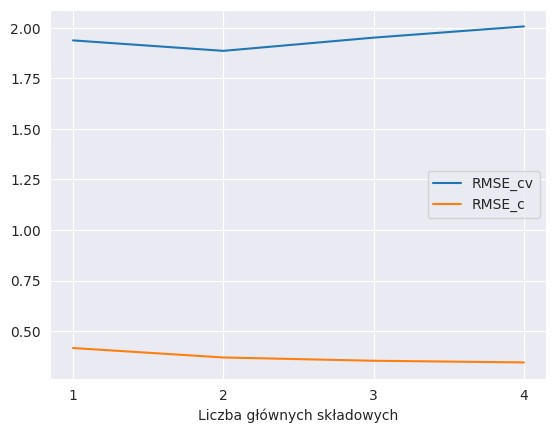

In [37]:
principal_component_plot(4, PC_training, Y_training_std)

Po analizie powyższego wykresu uważam, że istotną liczbą głównych składowych dla późniejszego zastosowania modelu jest 2. Moja opinia wynika ze względu na najniższą wartość $RMSE_{cv}$, czyli najstabilniejszy model oraz nieróżniącą się dużo wartością $RMSE_c$, czyli relatywnie dobrze przewidujący model dla danych kalibracyjnych.

In [38]:
significant_model = LinearRegression().fit(PC_training.select(pl.nth(range(0,2))), Y_training_std)

$R^2$

In [39]:
R2(
    significant_model.predict(PC_training.select(pl.nth(range(0,2)))).flatten(),
    Y_training_std
)

0.8557841688718717

$RMSE_c$

In [40]:
RMSE(
    significant_model.predict(PC_training.select(pl.nth(range(0,2)))).flatten(),
    Y_training_std
)

0.3690580449060811

$Q^2_{ext}$

In [41]:
Q2(
    significant_model.predict(PC_validation.select(pl.nth(range(0,2)))).flatten(),
    Y_validation
)

-2.692742042256873

$RMSE_{ext}$

In [42]:
RMSE(
    significant_model.predict(PC_validation.select(pl.nth(range(0,2)))).flatten(),
    Y_validation
)

1.6339934386300305

Otrzymany model wykorzystujący 2 główne składowe daje bardzo słabe wyniki. Analizując macierz korelacji wynika, że metoda PCR jest nie jest odpowiednia dla tego zestawu danych, ponieważ wartości bezwzględne są mniejsze od 0.7, czyli dane są słabo skorelowane.